## Introdução

Este projeto tem o objetivo de criar um modelo para a identificação de transações bancárias fraudulentas.

Dentre as principais etapas do processo, estão:

1. **Análise exploratória dos dados**
2. **Criação de novas features**
3. **Criação do modelo preditivo**
4. **Verificação da performance dos modelos**


### Biliotecas e Configurações

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from skopt import BayesSearchCV


mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting
color_palette = ['#003851ff', '#3F48F2', '#3F81F2', '#3FF2F2', '#9F7FF5', '#90B4F2']

# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(0.0, 0.2196078431372549, 0.3176470588235294),
 (0.24705882352941178, 0.2823529411764706, 0.9490196078431372),
 (0.24705882352941178, 0.5058823529411764, 0.9490196078431372),
 (0.24705882352941178, 0.9490196078431372, 0.9490196078431372),
 (0.6235294117647059, 0.4980392156862745, 0.9607843137254902),
 (0.5647058823529412, 0.7058823529411765, 0.9490196078431372)]

### Problema

Transações bancárias fraudulentas representam um grande problema para instituições em todo o mundo, dado o número crescente de novos golpes sendo criados. Tendo isso em mente, a utilização de métodos mais sofisticados para a detecção de atividades fraudulentas se tornou uma tarefa tão crucial quanto complexa.

Métodos como a análise de dados e a criação de modelos utilizando aprendizado de máquina têm sido de grande contribuição para a solução desses problemas, permitindo reconhecer e relacionar features importantes e relevantes para a tomada de decisões.

### Objetivo

- Identificar os fatores que revelam a confiabilidade das transações.
- Construir um modelo preditivo capaz de identificar com exatidão as transações fraudulentas.
- Identificar features relevantes para a detecção de transações suspeitas, possibilitando ações preventivas por parte do banco.

### Entendendo os dados

- O banco de dados foi retirado do kaggle: https://www.kaggle.com/datasets/ealaxi/paysim1

- Os dados contem colunas com informações como: quantia de transação, tipo de pagamento, tempo transcorrido, etc.

- Os dados são rotulados como 1 para fraudes e 0 para nao fraudes.

In [3]:
df = pd.read_csv('fraud_detection_dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Dicionario dos dados.

- **`step`**: representa uma unidade de tempo onde 1 passo equivale a 1 hora.
- **`type`**: tipo de transação online.
- **`amount`**: o valor da transação.
- **`nameOrig`**: cliente que inicia a transação.
- **`oldbalanceOrg`**: saldo antes da transação.
- **`newbalanceOrig`**: saldo após a transação.
- **`nameDest`**: destinatário da transação.
- **`oldbalanceDest`**: saldo inicial do destinatário antes da transação.
- **`newbalanceDest`**: o novo saldo do destinatário após a transação.
- **`isFraud`**: transação fraudulenta.

- **`isFlaggedFraud`**: SinalizadaComoFraude automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

- **`M`** e **`C`** Merchants(Comerciantes) e Customers(Cliente)

**`NOTA`**: As transações detectadas como fraude são canceladas, portanto para detecção de fraude estas colunas (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) não devem ser utilizadas.

Infomações gerais como: Quantidade de linhas, valores nulos e tipo de variaveis.

In [4]:
df.info(null_counts=True)

C:\Users\walla\AppData\Local\Temp\ipykernel_10856\1982639406.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Os valores discrepantes entre as variáveis 1 e 0 revelam um grande desbalanceamento nos dados, que deve ser levado em consideração ao avaliar as métricas, como, por exemplo, a acurácia. Isso porque, em um modelo que sempre classifica uma transação como não fraudulenta, ele acertaria 99,8% das vezes. No entanto, o rótulo mais importante para o nosso modelo é o reconhecimento de transações fraudulentas.

Podemos então analisar mais a fundo as variáveis categóricas. Para uma primeira análise, podemos observar a proporção de recorrência das mesmas. Primeiro, analisarei a coluna **`type`**, que se refere ao tipo de transação realizada.


In [8]:
print(f'A quantidade de valores únicos encontrados foi:{df["type"].nunique()}')
print(df['type'].value_counts(normalize=True))

A quantidade de valores únicos encontrados foi:5
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64


Podemos observar uma grande dominancia CASH_OUT, PAYMENT e CASH_IN. Observaremos a ocorrecia de fraudes para com as mesmas.

In [9]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Text(0, 0.5, 'Número de Fraudes')

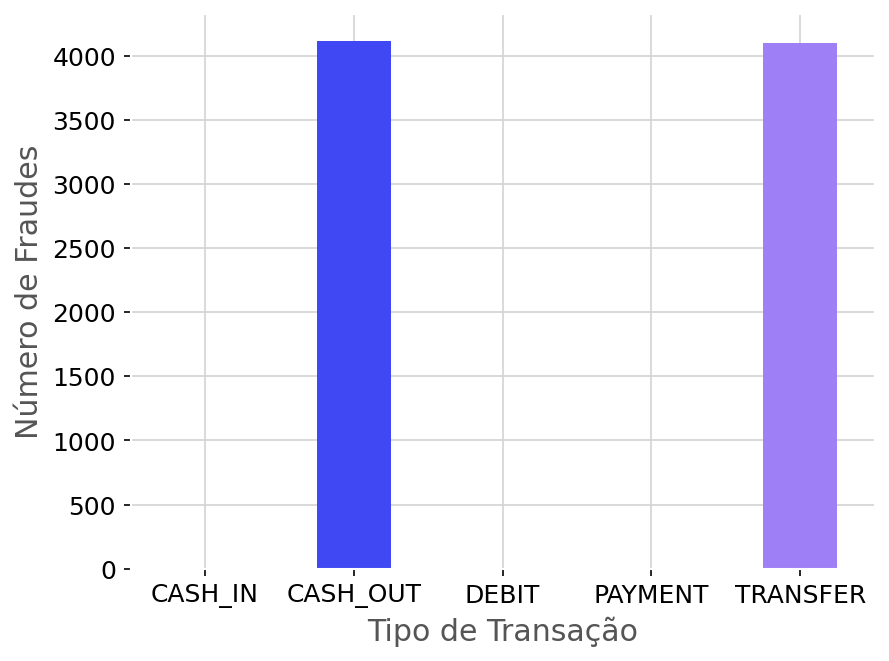

In [10]:
df.groupby('type').sum(numeric_only=True)['isFraud'].plot(kind='bar', color=color_palette,rot=0)
plt.xlabel('Tipo de Transação')
plt.ylabel('Número de Fraudes')



O gráfico mostra que apenas **`TRANSFER`** e **`CASH_OUT`** são utilizados para fraudes. Isso pode ocorrer devido aos métodos permitirem  a movimentação rápida e direta de dinheiro, o que facilitaria a retirada ou transferência de dinheiro para contas controladas pelos fraudadores.

Podemos tambem nos peguntar se um mesmo nome é recorrente em nossos dados.

In [11]:
print('Os 5 primeiros nomes de origem mais repetidopos: ')
print(df['nameOrig'].value_counts()[:5])
print('\nOs 5 primeiros nomes de destino mais repetidopos: ')
print(df['nameDest'].value_counts()[:5])

Os 5 primeiros nomes de origem mais repetidopos: 
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
Name: nameOrig, dtype: int64

Os 5 primeiros nomes de destino mais repetidopos: 
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
Name: nameDest, dtype: int64


A uma descrepencia entre a quantidade de nomes repetidos para os dois conjuntos. Faz sentido mais nomes repetidos em nomes de destinos visto ao relizar uma transferencia frauduleta, é necessario obter esse dinheiro apartir de uma conta tbm. Com isso em mete, podemos ver a quantidade de transações fraudulentas relacionadas a esses nomes.

In [12]:
print('Os 5 primeiros nomes de origem mais repetidopos, rotulados como fraudes: ')
print(df[df['isFraud']==1]['nameOrig'].value_counts()[:5])
print('\nOs 5 primeiros nomes de destino mais repetidopos rotulados como fraudes:')
print(df[df['isFraud']==1]['nameDest'].value_counts()[:5])

Os 5 primeiros nomes de origem mais repetidopos, rotulados como fraudes: 
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
Name: nameOrig, dtype: int64

Os 5 primeiros nomes de destino mais repetidopos rotulados como fraudes:
C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
Name: nameDest, dtype: int64


Obtemos poucos valores repetidos, revelendo nao ser um informação tão util. Para um ultimo teste podemos ver que no codigo escrito,  existe um letra e numeros aleatorios. Podemos nos perguntas  qual a relação entre transações de  clientes e mercantes, frente as fraudes.

In [13]:
from collections import Counter

print(Counter(''.join(df['nameOrig'].tolist())))
print(Counter(''.join(df['nameDest'].tolist())))



Counter({'1': 8803448, 'C': 6362620, '2': 6136135, '3': 5699596, '4': 5693146, '7': 5669437, '5': 5668010, '6': 5667725, '0': 5667074, '9': 5665212, '8': 5662637})
Counter({'1': 8799996, '2': 6133780, '3': 5704404, '4': 5691070, '8': 5675627, '9': 5668861, '7': 5665128, '0': 5664751, '6': 5662897, '5': 5662271, 'C': 4211125, 'M': 2151495})


Apenas as letras C e M aparecem no conjunto de dados nameDest. Podemos entao criar um rotulo para substituir essas duas colunas tentando relacionar essas letras entre colunas.

In [14]:
df['type2'] = np.nan
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('C'), 'type2'] = 'CC'
df.loc[df['nameOrig'].str.contains('C') & df['nameDest'].str.contains('M'), 'type2'] = 'CM'
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CM


Text(0, 0.5, 'Número de Fraudes')

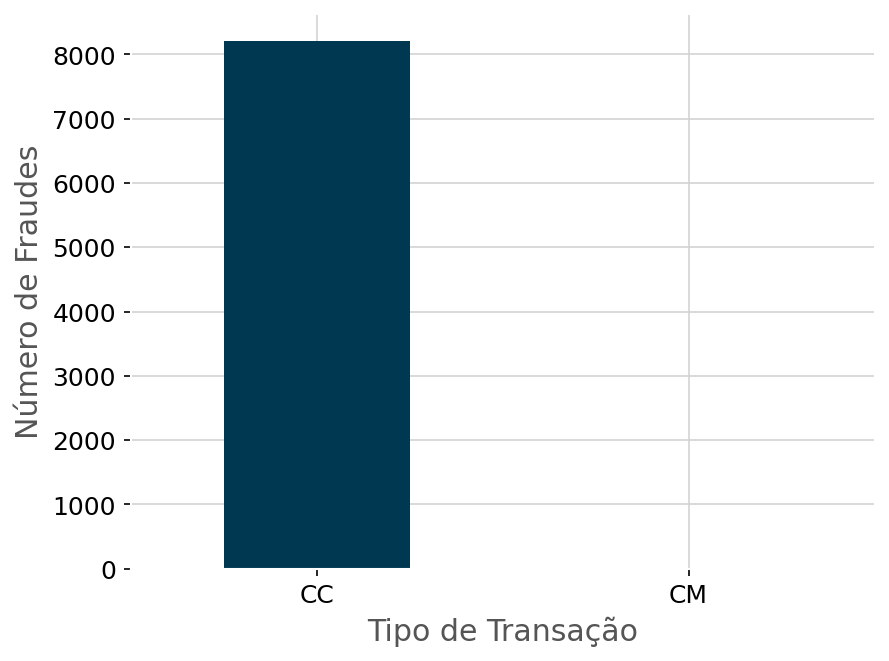

In [15]:
df.groupby('type2').sum(numeric_only=True)['isFraud'].plot(kind='bar', color=color_palette,rot=0)
plt.xlabel('Tipo de Transação')
plt.ylabel('Número de Fraudes')

O grafico mostra que apenas relação entre Cliente e Cliente apresentam trasações fraudulentas. Podemos entao substitur as duas colunas nameOrig e nameDest pela nova colunas type 2.

In [16]:
df.drop(['nameOrig', 'nameDest'], axis = 1, inplace= True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,CM
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,CM
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,CM


Agora analisanto a coluna step, podemos nos perguntar como se comporta essas transações no tempo. Primeiramente é necessario transfomar a coluna step para um melhor interpretação.

In [17]:
from datetime import datetime as dt
from datetime import timedelta as td

data_inicio = dt(2024, 1, 1, 0)
step_final = df['step'].max()
step_inicial = df['step'].min()
datas = [data_inicio]

for i in range(step_inicial, step_final):
    data_inicio += td(seconds=3600)
    datas.append(data_inicio)


df_datas = pd.DataFrame({'dates': datas})
df_datas['hour'] = df_datas['dates'].dt.hour
df_datas['step'] = df_datas.index + 1
df_datas.drop(['dates'], axis =1, inplace= True)
df_datas.head()

,hour,step
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [18]:
df = pd.merge(df, df_datas, on=['step'], how = 'left')

In [19]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2,hour
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,CM,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,CM,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,CC,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,CC,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,CM,0


0


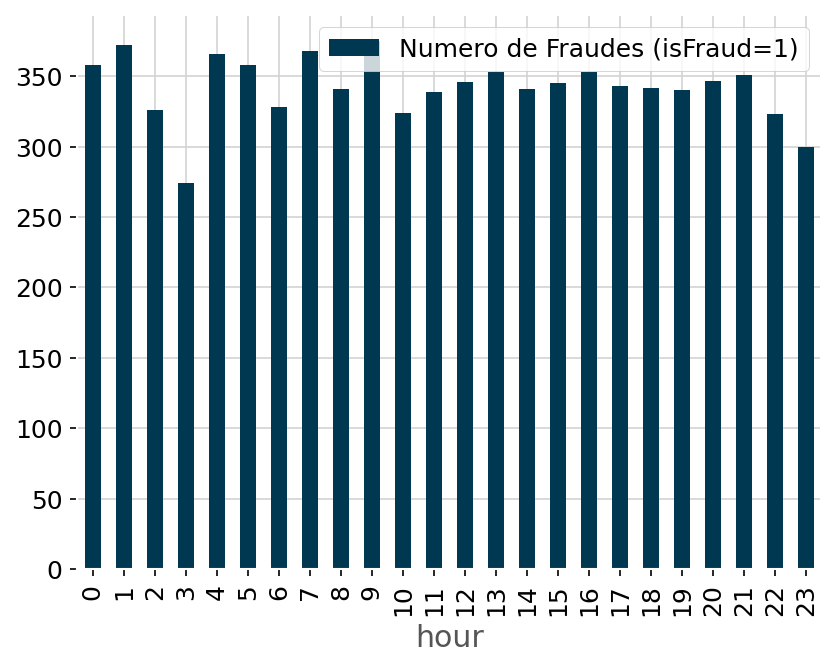

In [20]:

df_isFraud_fraud = df.groupby(['hour', 'isFraud']).size().reset_index(name='count').astype(int)
df_isFraud_fraud[df_isFraud_fraud['isFraud']==1].plot(kind = 'bar', x= 'hour', y = 'count')
plt.legend(['Numero de Fraudes (isFraud=1)'])
print(df['hour'].isna().sum())

O numero de transações fraudulentas aparenta tem um valor constante, visto que mantem a mesma ordem de grandeza para todos os horarios do dia. Porem é necessario saber a quantidade de transações totais realizada.

<Axes: xlabel='hour'>

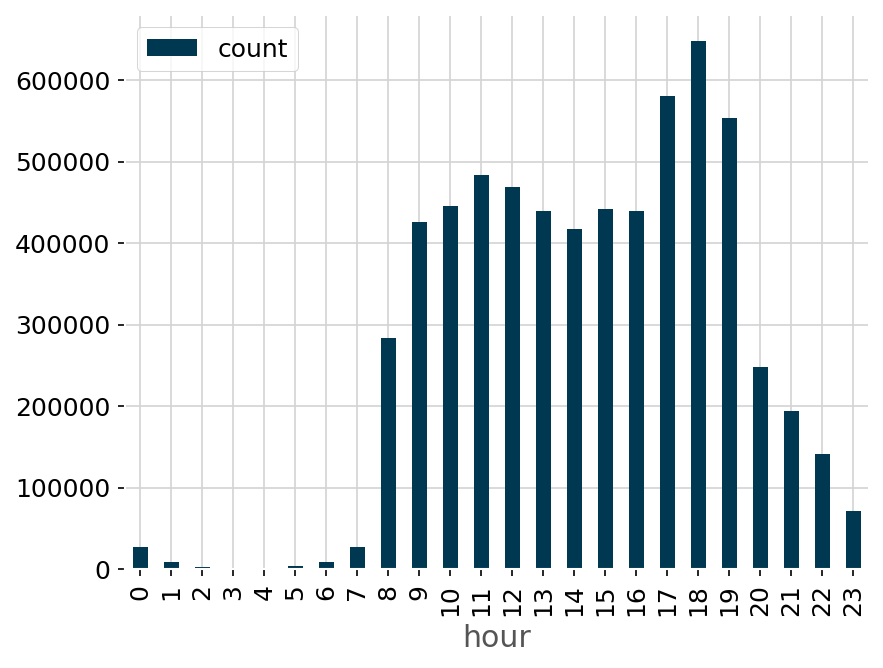

In [21]:

df.groupby(['hour']).size().reset_index(name='count').astype(int).plot(kind = 'bar', x= 'hour', y = 'count')



Podemos ver um numero bem reduzido de trasações no perido de 0 a 7 horas. Para um analise mais correta, é necessario analisarmos a proporção de trasações fraudulentas em cada perido, visto que o numero de trasações fraudulentas em  compração a um baixo numero de trasações totais é bem mais relevante do que o mesmo valor em um numero elevado de trasações feita no dia.

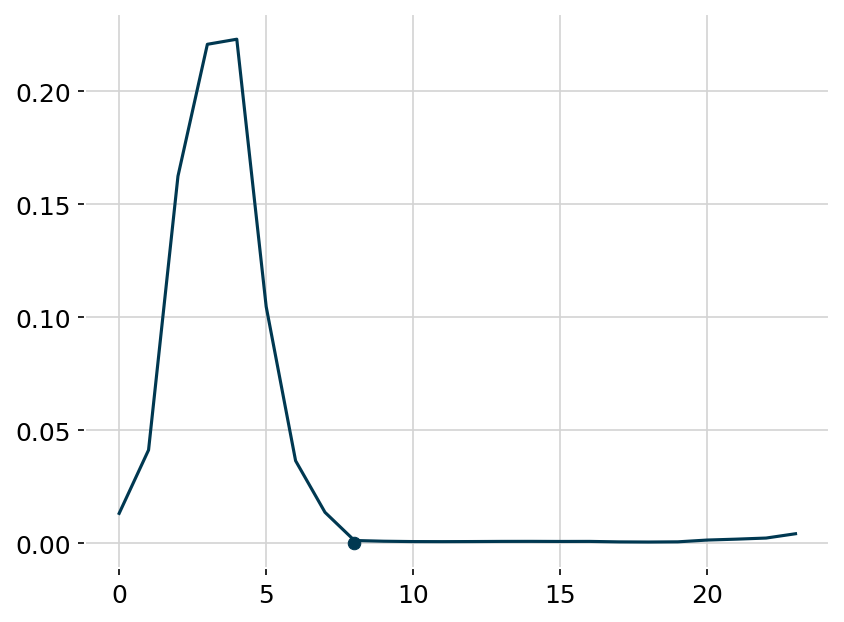

In [22]:
pro = np.array(df_isFraud_fraud[df_isFraud_fraud['isFraud'] == 1]['count']) / np.array(df_isFraud_fraud.groupby(['hour']).sum()['count'])
plt.plot(pro)
plt.scatter(x = 8, y = 0)

Podemos agopra criar uma classe agora que diga qual o periodo a trasação foi realizada.

In [23]:
df_horas_classe = pd.DataFrame({'hour':       [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                'hour_class': [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}, dtype=int)



df = pd.merge(df, df_horas_classe, on=['hour'], how = 'left')

In [24]:
df.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2,hour,hour_class
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,CM,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,CM,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,CC,0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,CC,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,CM,0,1


Agora podemos tirar as colunas que não são mais relevantes. Tambem existe um nota no site de obteção do conjuito de dados que alerta a nao utulizar as colunas de oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest na criação de modelos de predição.

In [25]:
df.drop(['step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','hour','isFlaggedFraud'],axis = 1, inplace= True)
df.head()


,type,amount,isFraud,type2,hour_class
0,PAYMENT,9839.64,0,CM,1
1,PAYMENT,1864.28,0,CM,1
2,TRANSFER,181.00,1,CC,1
3,CASH_OUT,181.00,1,CC,1
4,PAYMENT,11668.14,0,CM,1



## Preprocessamento

- Antes de começar todos os próximos passos, farei a separação entre o conjunto de treino e o de teste.

- Todos os passos serão voltados para o conjunto de treino, assim evitamos o vazamento de dados, garantindo uma boa representação e avaliação correta do modelo com novos dados de teste, devido ao isolamento prévio.

- Defini a função `stratify=True` para garantir um processo de divisão realista, visto que isso mantém a proporção original dos dados.

In [26]:
df_features = df.drop('isFraud', axis= 1)
df_target = df['isFraud']

In [27]:
smote = RandomUnderSampler()
df_features, df_target = smote.fit_resample(
    df_features,
    df_target,
    )

y_train_resampled_series = pd.Series(df_target)
y_train_resampled_series.value_counts()

0    8213
1    8213
Name: isFraud, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df_target, test_size=0.2, shuffle=True, stratify = df_target)

Tambem é necessario normalizar os dados numericos, visto que esses algoritmos utilizam cálculos baseados em distância ou algoritmos de otimização, gradient descent, sensivel a escala dos numeros. ja para o a coluna categorica 'type' e 'type2' utilizaremos one-gotEncoder, pelo fato das mesma não apresetarem uma graus de importancia entre suas proprias varaveis. (REVISAR)

In [29]:
label_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded = label_encoder.fit_transform(X_train[['type', 'type2']])
X_test_encoded = label_encoder.transform(X_test[['type','type2']])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=label_encoder.get_feature_names_out())
X_test_encoded = pd.DataFrame(X_test_encoded, columns=label_encoder.get_feature_names_out())



In [30]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

X_train.head()

,index,type,amount,type2,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,5545406,CASH_OUT,1595587.46,CC,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,480463,TRANSFER,161939.36,CC,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,4744886,PAYMENT,5778.22,CM,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2382144,TRANSFER,436035.29,CC,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,6118836,CASH_OUT,254773.22,CC,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [31]:
X_train.drop(['type','type2'], axis =1 ,inplace=True)
X_test.drop(['type','type2'], axis = 1,inplace=True)
X_train.head()


,index,amount,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,5545406,1595587.46,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,480463,161939.36,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,4744886,5778.22,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2382144,436035.29,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,6118836,254773.22,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [32]:
scaler = StandardScaler()

X_train['amount_scaled'] = scaler.fit_transform(X_train[['amount']])
X_test['amount_scaled'] = scaler.fit_transform(X_test[['amount']])
X_test.head()


,index,amount,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,amount_scaled
0,1030258,112668.54,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.372170
1,2249038,104044.64,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.377007
2,4223384,3763.44,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.433251
3,6009394,3947541.37,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.778682
4,1431440,375141.86,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.224957


In [33]:
X_train.drop(['amount'], axis =1 ,inplace=True)
X_test.drop(['amount'], axis = 1,inplace=True)
X_train.head()

,index,hour_class,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,amount_scaled
0,5545406,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.412348
1,480463,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.358475
2,4744886,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.442437
3,2382144,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.211103
4,6118836,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.308561


In [34]:
tree_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}


def classification_kfold_cv(models, X_train, y_train, n_folds=5):
    results = []
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for name, model in models.items():
        cv_scores_ac = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
        cv_scores_re = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
        cv_scores_pre = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision')
        cv_scores_f1 = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
        results.append({
            "Model": name,
            "Mean Accuracy": cv_scores_ac.mean(),
            "Mean recall": cv_scores_re.mean(),
            'Mean precision':cv_scores_pre.mean(),
            'Mean f1':cv_scores_f1.mean()
        })
    
    return pd.DataFrame(results)

eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train, 
                                  y_train=y_train, 
                                  n_folds=5)

print(eval_df)

                 Model  Mean Accuracy  Mean recall  Mean precision   Mean f1
0  Logistic Regression       0.500000     1.000000        0.500000  0.666572
1        Random Forest       0.894444     0.887340        0.901511  0.894658
2              XGBoost       0.906469     0.893627        0.917262  0.905228


In [35]:
param_grid = {
    'n_estimators': [100, 200,300,400],
    'max_depth': (3, 25),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'colsample_bytree': (0.1, 1.0),
    'subsample': (0.1, 1.0),
    'gamma': (0, 15),
    'min_child_weight': (1, 20)
}

rfc = XGBClassifier()
opt = BayesSearchCV(rfc, param_grid, n_iter=32, cv=3, n_jobs=-1)

In [36]:

opt.fit(X_train, y_train)
y_pred = opt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1643
           1       0.91      0.89      0.90      1643

    accuracy                           0.90      3286
   macro avg       0.90      0.90      0.90      3286
weighted avg       0.90      0.90      0.90      3286



In [37]:
print("Melhores hiperparâmetros:", opt.best_params_)

Melhores hiperparâmetros: OrderedDict([('colsample_bytree', 0.916673017636254), ('gamma', 1), ('learning_rate', 0.024405869282502064), ('max_depth', 18), ('min_child_weight', 12), ('n_estimators', 400), ('subsample', 0.4590282983925006)])


In [38]:
final_model = LogisticRegression()

# Treine o modelo com o conjunto de dados completo
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1643
           1       0.50      1.00      0.67      1643

    accuracy                           0.50      3286
   macro avg       0.25      0.50      0.33      3286
weighted avg       0.25      0.50      0.33      3286



C:\Users\walla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\walla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\walla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469

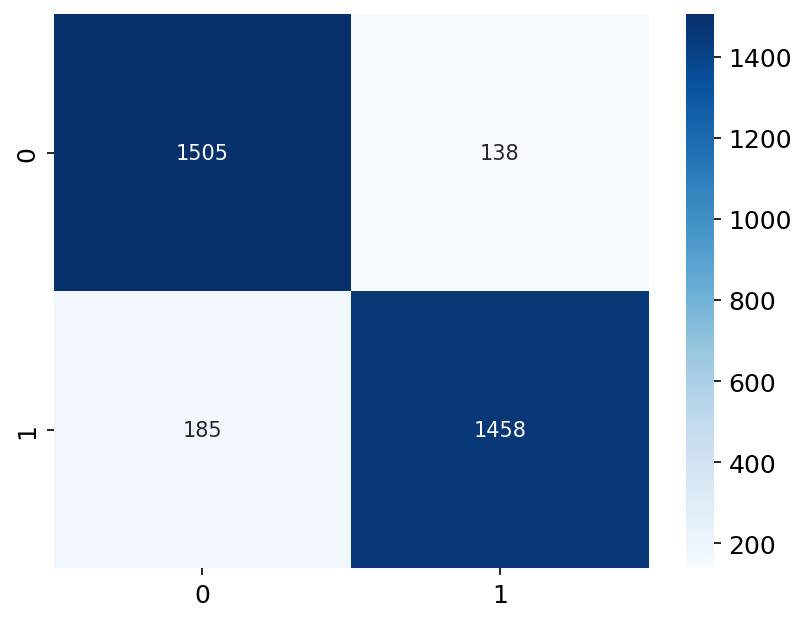

In [39]:
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

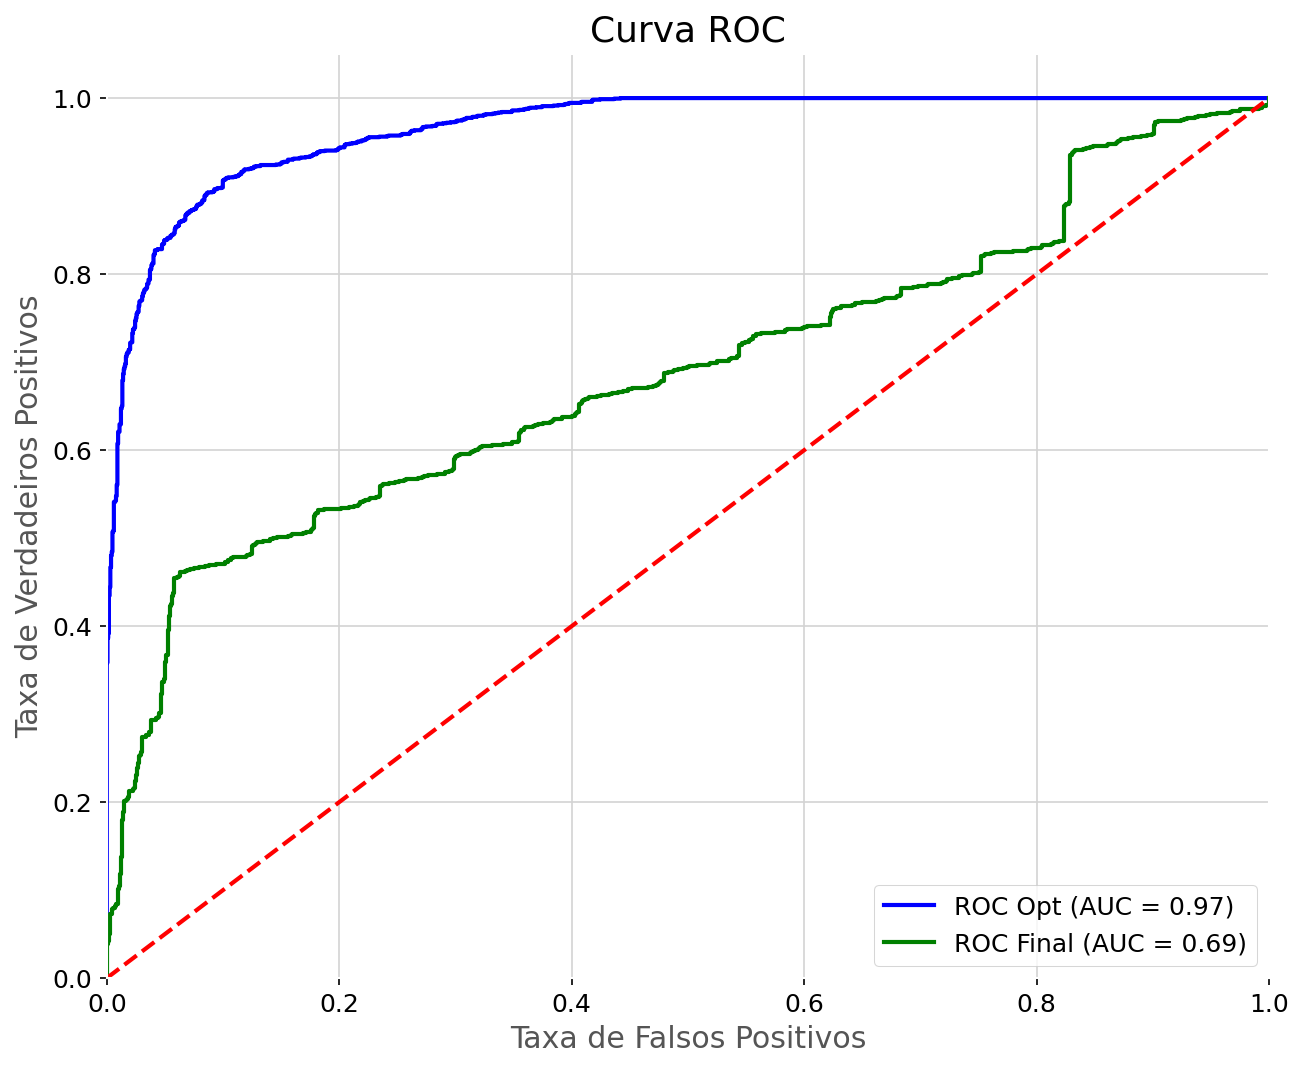

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Para o modelo ajustado com BayesSearchCV
y_pred_proba_opt = opt.predict_proba(X_test)[:, 1]  # Pegue as probabilidades para a classe positiva
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_proba_opt)
roc_auc_opt = auc(fpr_opt, tpr_opt)

# Para o modelo final
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]
fpr_final, tpr_final, _ = roc_curve(y_test, y_pred_proba_final)
roc_auc_final = auc(fpr_final, tpr_final)

# Plotar a curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_opt, tpr_opt, color='blue', lw=2, label='ROC Opt (AUC = %0.2f)' % roc_auc_opt)
plt.plot(fpr_final, tpr_final, color='green', lw=2, label='ROC Final (AUC = %0.2f)' % roc_auc_final)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
